In [36]:
import os
import pandas as pd
import numpy as np
import math

from matplotlib import offsetbox
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import layers
from keras.utils.np_utils  import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import cv2
from typing import Tuple
from tqdm import tqdm
from PIL import Image
# import visualkeras


In [37]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [38]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


In [39]:
file_path = 'data/greyscale.npy.npz'
arrays = np.load(file_path)

# To access the arrays, use their keys (you can see them by printing arrays.files)
print(arrays.files)  # This will print the list of keys

# Access a specific array using its key
array_1 = arrays['arr_0']  # Replace 'key_1' with the actual key name
faces = array_1

# faces_2d = faces[:,0,:,:,:]
faces_2d.shape

['arr_0']


(358, 224, 224, 1)

In [40]:
index_to_pop = [41, 55, 58, 71, 79, 80, 83, 90, 103, 120, 121, 143, 159, 166, 170, 187, 190, 203, 205, 212, 232, 245, 270, 275, 282, 285, 301, 309, 310, 314, 322, 324, 331, 332, 355, 357, 366, 372, 375, 379, 380, 392]

y = [0 if val!="FAKE" else 1 for val in labels_col ]
y = np.array(y)
y = np.delete(y, index_to_pop)
y = to_categorical(y, num_classes=None).astype(int)

In [41]:
train_size = 0.7
X = faces_2d    # dataset of faces
Y = y           # labels

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=train_size)

test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)


(250, 224, 224, 1) (250, 2)
(76, 224, 224, 1) (76, 2)
(32, 224, 224, 1) (32, 2)


In [42]:
def build_2D_model_nb(input_data):
    model = keras.models.Sequential()
    # model.add(layers.Conv2D(filters=32, kernel_size=(7,7), padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation="relu"))
    # model.add(layers.Dropout(0.5))
    
    #OUTPUT
    model.add(layers.Dense(2, activation="softmax"))

    return model

def compile_2D_model(model, lr):
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    metrics=["accuracy"]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [43]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

model_2d = build_2D_model_nb(faces_2d)
model_2d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [44]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
model_2d.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_test = model_2d.fit(X_train, 
                          y_train,
                          epochs=15, 
                          batch_size=30, 
                          verbose=2,
                          class_weight=class_weights,
                          validation_data=(X_valid, y_valid)
                          )

Epoch 1/15
9/9 - 8s - loss: 1.0976 - accuracy: 0.3840 - val_loss: 0.6576 - val_accuracy: 0.8438 - 8s/epoch - 916ms/step
Epoch 2/15
9/9 - 8s - loss: 0.6972 - accuracy: 0.8040 - val_loss: 0.5919 - val_accuracy: 0.8438 - 8s/epoch - 837ms/step
Epoch 3/15
9/9 - 8s - loss: 0.6952 - accuracy: 0.7000 - val_loss: 0.6460 - val_accuracy: 0.7812 - 8s/epoch - 888ms/step
Epoch 4/15
9/9 - 8s - loss: 0.6824 - accuracy: 0.7960 - val_loss: 0.6265 - val_accuracy: 0.5938 - 8s/epoch - 923ms/step
Epoch 5/15
9/9 - 8s - loss: 0.6664 - accuracy: 0.6400 - val_loss: 0.6043 - val_accuracy: 0.5000 - 8s/epoch - 906ms/step
Epoch 6/15
9/9 - 8s - loss: 0.6224 - accuracy: 0.4760 - val_loss: 0.5846 - val_accuracy: 0.6562 - 8s/epoch - 902ms/step
Epoch 7/15
9/9 - 8s - loss: 0.5894 - accuracy: 0.5520 - val_loss: 0.6540 - val_accuracy: 0.4688 - 8s/epoch - 904ms/step
Epoch 8/15
9/9 - 8s - loss: 0.5281 - accuracy: 0.6440 - val_loss: 0.5631 - val_accuracy: 0.8125 - 8s/epoch - 924ms/step
Epoch 9/15
9/9 - 8s - loss: 0.4861 - acc

Text(0.5, 0, 'epoch')

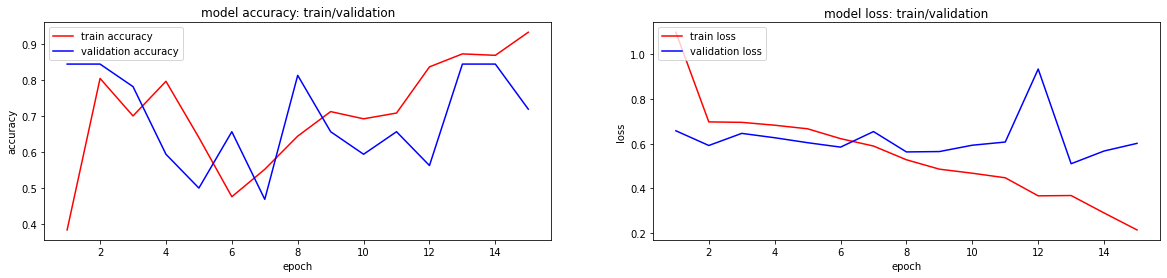

In [47]:
acc = history_test.history['accuracy']
val_acc = history_test.history['val_accuracy']
loss = history_test.history['loss']
val_loss = history_test.history['val_loss']
epochs = np.arange(1,len(history_test.history['accuracy'])+1)

plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title(f'model accuracy: train/validation')
plt.plot(epochs, acc, color="red", label="Training Acc")
plt.plot(epochs, val_acc, color="blue", label="Validation Acc")
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.title(f'model loss: train/validation')
plt.plot(epochs, loss, color="red", label="Loss Acc")
plt.plot(epochs, val_loss, color="blue", label="Loss Acc")
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

ValueError: num must be 1 <= num <= 2, not 3

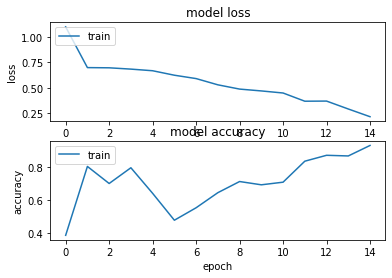

In [46]:
keys = history_test.history.keys()
for idx,key in enumerate(keys): 
    plt.subplot(2, 1, idx+1)
    plt.plot(history_test.history[key])
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

12/12 [==============================] - 4s 362ms/step
              precision    recall  f1-score   support

           0      0.678     0.871     0.762        70
           1      0.966     0.899     0.932       288

    accuracy                          0.894       358
   macro avg      0.822     0.885     0.847       358
weighted avg      0.910     0.894     0.899       358



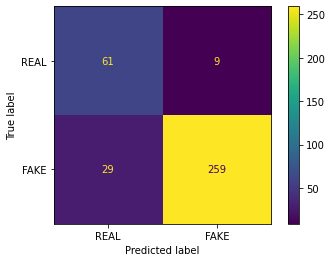

In [ ]:
pred_y = model_2d.predict(faces_2d)
actual_y = np.argmax(y[:faces_2d.shape[0]], axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))
cfm = confusion_matrix(actual_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()
